In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from tqdm import tqdm
from torch.utils.data import DataLoader

In [2]:
cyclone_events = np.load('data/ERA5/ERA5_MSL_1982_2020_3h_0.75/cyclones_events.npz')
closeness_w = np.load('data/ERA5/ERA5_MSL_1982_2020_3h_0.75/metrics_corr_land_masked_and_preproc_window_2d_delay_0d/probability_for_metrics/diff_metrics/network_metrics/closeness_w.npy')
degree_w = np.load('data/ERA5/ERA5_MSL_1982_2020_3h_0.75/metrics_corr_land_masked_and_preproc_window_2d_delay_0d/probability_for_metrics/diff_metrics/network_metrics/degree_w.npy')
EVC_w = np.load('data/ERA5/ERA5_MSL_1982_2020_3h_0.75/metrics_corr_land_masked_and_preproc_window_2d_delay_0d/probability_for_metrics/diff_metrics/network_metrics/EVC_w.npy')
LCC_w = np.load('data/ERA5/ERA5_MSL_1982_2020_3h_0.75/metrics_corr_land_masked_and_preproc_window_2d_delay_0d/probability_for_metrics/diff_metrics/network_metrics/LCC_w.npy')
MSLP_preproc = np.load('data/ERA5/ERA5_MSL_1982_2020_3h_0.75/metrics_corr_land_masked_and_preproc_window_2d_delay_0d/probability_for_metrics/input_data/MSLP_preproc.npy')

In [3]:
cyclone_events_2 = cyclone_events[cyclone_events.files[0]]
cyclone_events_4 = cyclone_events[cyclone_events.files[1]]
cyclone_events_6 = cyclone_events[cyclone_events.files[2]]
cyclone_events_8 = cyclone_events[cyclone_events.files[3]]
cyclone_events_10 = cyclone_events[cyclone_events.files[4]]
cyclone_events_12 = cyclone_events[cyclone_events.files[5]]

In [4]:
cyclone_events_2.shape

(36, 69, 113960)

In [5]:
MSLP_preproc = np.reshape(MSLP_preproc, (36, 69, 113960))

In [6]:
labels = np.zeros(113960)

for i in range(113960):
    if len(cyclone_events_2[:, :, i][cyclone_events_2[:, :, i] != False]) > 0:
        labels[i] = 1

In [7]:
'''
cyclone_occurances = []
no_cyclone = []
for i in range(113960):
    if len(cyclone_events_2[:, :, i][cyclone_events_2[:, :, i] != False]) > 0:
        cyclone_occurances.append(i)
    else:
        no_cyclone.append(i)
        
import random
random.shuffle(cyclone_occurances)
random.shuffle(no_cyclone)    

f1 = open("shuffle_cyclone.csv", "w")
f2 = open("shuffle_no_cyclone.csv", "w")
[f1.write(str(item) + ',') for item in cyclone_occurances]
[f2.write(str(item) + ',') for item in no_cyclone]
f1.close()
f2.close()
'''

'\ncyclone_occurances = []\nno_cyclone = []\nfor i in range(113960):\n    if len(cyclone_events_2[:, :, i][cyclone_events_2[:, :, i] != False]) > 0:\n        cyclone_occurances.append(i)\n    else:\n        no_cyclone.append(i)\n        \nimport random\nrandom.shuffle(cyclone_occurances)\nrandom.shuffle(no_cyclone)    \n\nf1 = open("shuffle_cyclone.csv", "w")\nf2 = open("shuffle_no_cyclone.csv", "w")\n[f1.write(str(item) + \',\') for item in cyclone_occurances]\n[f2.write(str(item) + \',\') for item in no_cyclone]\nf1.close()\nf2.close()\n'

In [8]:
data = MSLP_preproc.copy()

In [9]:
cyclone_occurances = pd.read_csv("shuffle_cyclone.csv", header=None)
no_cyclone = pd.read_csv("shuffle_no_cyclone.csv", header=None)

np.nan_to_num(data, nan=0, copy=False)

cyclone_occurances = cyclone_occurances.values[0]
no_cyclone = no_cyclone.values[0]

cut_cyclone = int(0.8 * len(cyclone_occurances))
cut_no_cyclone = int(0.8 * len(no_cyclone))


train_id = cyclone_occurances[:cut_cyclone].astype(int)
train_id = np.append(train_id, no_cyclone[:cut_no_cyclone].astype(int))

test_id = cyclone_occurances[cut_cyclone:-1].astype(int) 
test_id = np.append(test_id, no_cyclone[cut_no_cyclone:-1].astype(int))

train_data = torch.tensor(data[:, :, train_id], dtype=torch.double)
test_data = torch.tensor(data[:, :, test_id], dtype=torch.double)

labels_train = torch.tensor(labels[train_id])
labels_test = torch.tensor(labels[test_id])

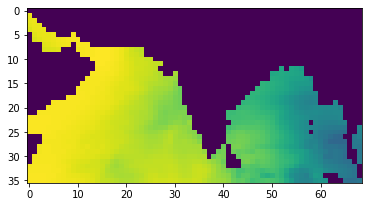

In [10]:
plt.imshow(data[:, :, 41000])

In [11]:
import math
def conv2d_size_out(size, kernel_size=5, stride=2):
    """
    common use case:
    cur_layer_img_w = conv2d_size_out(cur_layer_img_w, kernel_size, stride)
    cur_layer_img_h = conv2d_size_out(cur_layer_img_h, kernel_size, stride)
    to understand the shape for dense layer's input
    """
    return (size - (kernel_size - 1) - 1) // stride  + 1

def maxpool2d_size_out(size, kernel_size=2, stride=2):
    return math.floor((size - (kernel_size - 1) - 1) / stride + 1)

In [23]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=36,            
                kernel_size=5,          
                stride=2),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        
        new_w = maxpool2d_size_out(conv2d_size_out(36, 5, 2), 2, 2)
        new_h = maxpool2d_size_out(conv2d_size_out(69, 5, 2), 2, 2)
        
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=36,              
                out_channels=72,            
                kernel_size=5,          
                stride=2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )        
        
        new_w = maxpool2d_size_out(conv2d_size_out(new_w, 5, 2), 2, 2)
        new_h = maxpool2d_size_out(conv2d_size_out(new_h, 5, 2), 2, 2)
        linear_input_size = new_w * new_h * 72
        # fully connected layer, output 10 classes
        self.lin = nn.Linear(linear_input_size, 1) 
        self.out = nn.Sigmoid()
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)      
        
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        x = self.lin(x)
        output = self.out(x)
        return output, x    
        

In [41]:
cnn = CNN()
loss_func = nn.CrossEntropyLoss() 
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)  

In [49]:
num_epochs = 1

def train(num_epochs, cnn, train_data, labels_train):  
    cnn.train()
    
    cnn = cnn.double()
        
    # Train the model
    batch_size = 1
        
    for epoch in range(num_epochs):
        for i in tqdm(range(int(train_data.shape[2] / batch_size))):
            
            image = train_data[:, :, i]
            label = labels_train[i]
            
            image = image.unsqueeze(0) 
            image = image.unsqueeze(0) 
            label = label.unsqueeze(0) 
            label = label.unsqueeze(0) 
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(image)   # batch x
            b_y = Variable(label)   # batch y
            output = cnn(b_x)[0]  
            loss = loss_func(output, b_y)
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()                # apply gradients             
            optimizer.step()  
        
        pass
    pass

train(num_epochs, cnn, train_data, labels_train)

100%|███████████████████████████████████████████████████████████████████████████| 91168/91168 [02:43<00:00, 559.00it/s]


In [55]:
def test(test_data, labels_test):
    # Test the model
    cnn.eval()    
    with torch.no_grad():
        correct = 0
        total = 0
        tp = 0
        fp = 0
        fn = 0
        tn = 0
        for i in range(test_data.shape[2]):
            image = test_data[:, :, i]
            label = labels_test[i]
            image = image.unsqueeze(0) 
            image = image.unsqueeze(0) 
            
            test_output, last_layer = cnn(image)
            pred_y = 0 if test_output[0] > 0.5 else 1
            if (pred_y == label and label == 1):
                tp += 1
            elif (pred_y == label and label == 0):
                tn += 1
            elif (pred_y != label and label == 1):
                fn += 1
            elif (pred_y != label and label == 0):
                fp += 1
            pass
        sensitivity = tp / (tp + fn)
        specificity = tn / (fp + tn)
        balanced_accuracy = (sensitivity + specificity) / 2
        print(f'Test Accuracy of the model on the {test_data.shape[2]} test images: %.2f' % balanced_accuracy)
    
    pass
test(test_data, labels_test)



Test Accuracy of the model on the 22792 test images: 0.49
